In [12]:
import pandas as pd
from IPython.display import display
import os
import json
import spacy
from spacy.tokens import Doc
from spacy.lang.pt.examples import sentences 

from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt 
from spacy.lang.pt.stop_words import STOP_WORDS

import requests
from bs4 import BeautifulSoup
import time

#spacy.cli.download("pt_core_news_sm")


In [2]:
nlp = spacy.load('pt_core_news_sm')

punctuations = list(punctuation)

In [14]:
def extract_data_from_json(folder_path):
    """
    Extracts 'url' and 'timestamp' from all JSON files in the specified folder and stores them in a DataFrame.
    
    :param folder_path: Path to the folder containing JSON files.
    :return: A pandas DataFrame with columns 'url' and 'timestamp'.
    """
    data = []

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is a JSON file
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            # Open and load the JSON file
            with open(file_path, 'r', encoding='utf-8') as file:
                try:
                    json_data = json.load(file)
                    # Check if the data is a list of dictionaries
                    if isinstance(json_data, list):
                        for entry in json_data:
                            # Extract 'url' and 'timestamp' if available
                            if 'url' in entry and 'timestamp' in entry:
                                data.append({
                                    'url': entry['url'],
                                    'timestamp': entry['timestamp']
                                })
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON file {file_name}: {e}")

    # Convert collected data into a DataFrame
    df = pd.DataFrame(data, columns=['url', 'timestamp'])
    return df


In [15]:
df = extract_data_from_json("/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/cdx_results_json_files/data")

In [ ]:
# Create a DataFrame to store the data analysed

df = pd.DataFrame({
    "Newspaper": [],
    "Number of occurences": [],
    "Period": []
    })


# Newspapers to search

newsp = ['cmjornal.pt/', 
         'dn.pt/',
         'expresso.pt/',
         'folhanacional.pt/',
         'jn.pt/',
         'ionline.sapo.pt/',   
         'sol.sapo.pt/',
         'observador.pt/',
         'publico.pt/',
         'sabado.pt/',
         'sapo.pt/',
         'visao.pt/',
         ]

# Years of the analysis

years = ['2019', '2020-2021', '2022-2024']

# Counting the number of occurrences for each of the newspapers in the defined periods

for y in years:
    with open("/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/cdx_results_json_files/cdx_results_"+y+".json", "r") as f:
        data = f.read()
        for i in newsp:
                total = data.count(i)
                df.loc[len(df)] = [i, total, y]

# Count the number of occurrences of each item in the URL column and save it to the dataframe w/o the timestamp

yearly_data = {}
yearly_data_no_dupl = {}
df_no_dupl = {}

for y in years:
    # Read the dataframe, count the number of URLs, merge the count to original DF and then remove all duplicates based on URL
    df = pd.read_json("/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/cdx_results_json_files/cdx_results_"+y+".json")

    # Count the repeated urls in each of the .json files
    url_count = df.groupby(df['url']).size().reset_index(name = 'url count')

    # Merge the column (list) of counted values per url into the original DF
    yearly_data[f"df_{y}"] = df.merge(url_count, on = 'url', how = 'left')
    
    # Add the dataframes into a new dictionary
    yearly_data_no_dupl[f"df_{y}"] = yearly_data[f"df_{y}"].drop_duplicates(subset = ['url'], keep = 'first')


,url,timestamp,status,url count
0,https://www.cmjornal.pt/c-studio/especiais-c-s...,1970-08-22 19:13:46.174855,200,9
1,https://www.cmjornal.pt/c-studio/especiais-c-s...,1970-08-22 19:13:47.174619,200,9
2,https://www.cmjornal.pt/c-studio/especiais-c-s...,1970-08-22 19:13:48.171922,200,9
3,https://www.cmjornal.pt/c-studio/especiais-c-s...,1970-08-22 19:13:49.172316,200,9
4,https://www.cmjornal.pt/c-studio/especiais-c-s...,1970-08-22 19:13:50.181128,200,9


In [4]:
# Function to process the title
def title_input(df, year): 
    processed_texts = []  # Initialize inside the function

    # Extract the last part of each URL and process it with SpaCy
    last_part = df['url'].str.rsplit('/').str[-1]
    for part in last_part:
        if "-" in part:
            parts = part.rsplit('-')[0:-1]  # Split by '-' and remove the last element
            sentence = " ".join(parts)  # Join parts to form a sentence
            processed_sentence = nlp(sentence)  # Process with SpaCy
            processed_texts.append(" ".join(token.text for token in processed_sentence))
        else:
            processed_texts.append("")  # Append an empty string if no processing was done

    # Use .loc to avoid SettingWithCopyWarning
    df = df.copy()  # Create a copy to avoid SettingWithCopyWarning if df is a slice
    df.loc[:, 'processed_url_text'] = processed_texts
    
    # Drop duplicates based on the 'processed_url_text' column within the df DataFrame
    df = df.drop_duplicates(subset=['processed_url_text'], keep='first').reset_index(drop=True)
    
    # Update the original DataFrame dictionary with the filtered DataFrame
    yearly_data_no_dupl[f"df_{year}"] = df
    
    return df


In [5]:
# Function to filter the dataframe, for links with "chega" and "andre ventura"
def filter_dataframe(df, text_column="processed_url_text"):
    # List to keep track of row indices that meet the criteria
    indices_to_keep = []

    # Iterate over each row in the DataFrame to access both the index and text
    for index, row in df.iterrows():
        text = row[text_column]
        
        # Skip if the text is NaN
        if pd.isna(text):
            continue
        
        doc = nlp(text)

        # Check if "chega" appears as a noun in the document
        is_chega_noun = any(token.text.lower() == "chega" and token.pos_ == "NOUN" for token in doc)

        # Check if both "andre" and "ventura" appear in the document
        contains_andre_ventura = "andre" in text.lower() and "ventura" in text.lower()

        # If either condition is met, keep the row index
        if is_chega_noun or contains_andre_ventura:
            indices_to_keep.append(index)

    # Filter the DataFrame to only include rows that meet the criteria
    df = df.loc[indices_to_keep].reset_index(drop=True)
    
    return df


In [6]:
# Create a dictionary to store the filtered dataframes

filtered_dfs = {}
# Apply the title_input and filter_dataframe functions
for y in years:
    yearly_data_no_dupl[f"df_{y}"] = title_input(yearly_data_no_dupl[f"df_{y}"], y)
    filtered_dfs[f"filtered_df_{y}"] = filter_dataframe(yearly_data_no_dupl[f"df_{y}"])
    filtered_dfs[f"filtered_df_{y}"] = filtered_dfs[f"filtered_df_{y}"].rename(columns={"processed_url_text": "title"})

print(filtered_dfs['filtered_df_2019'])

                                                  url  \
0   https://www.cmjornal.pt/famosos/amp/irma-de-lu...   
1   https://www.cmjornal.pt/famosos/detalhe/irma-d...   
2   https://www.cmjornal.pt/opiniao/colunistas/edu...   
3   https://www.cmjornal.pt/politica/amp/andre-ven...   
4   https://www.cmjornal.pt/politica/amp/andre-ven...   
..                                                ...   
83  https://ionline.sapo.pt/artigo/679333/projeto-...   
84  https://www.sapo.pt/noticias/amp/nacional/depu...   
85  https://www.sapo.pt/noticias/motores/skoda-kos...   
86  https://www.sapo.pt/noticias/nacional/listas-d...   
87  https://www.sapo.pt/noticias/nacional/ventura-...   

                    timestamp  status  url count  \
0  1970-08-22 16:23:46.194334     200          1   
1  1970-08-22 16:23:46.204109     200          1   
2  1970-08-22 16:36:58.180706     200          2   
3  1970-08-22 16:37:08.191131     200          6   
4  1970-08-22 16:37:06.194953     200          2   
.. 

In [7]:
# Function to find the newspaper name in the URL
def find_newspaper(url):
    for newspaper in newsp:
        if newspaper in url:
            return newspaper
    return None  # Return None if no newspaper is found

# Create the 'newspaper' column
for y in years:
    filtered_dfs[f"filtered_df_{y}"]['newspaper'] = filtered_dfs[f"filtered_df_{y}"]['url'].apply(find_newspaper)

filtered_dfs['filtered_df_2022-2024']

,url,timestamp,status,url count,title,newspaper
0,https://www.cmjornal.pt/mais-cm/perguntas-cm/d...,1970-08-23 06:27:01.001045,200,1,imigracao aceita se referendo exigido pelo che...,cmjornal.pt/
1,https://www.cmjornal.pt/politica/detalhe/edite...,1970-08-23 00:46:41.183725,200,2,edite estrela e adao e silva sao os novos vice...,cmjornal.pt/
2,https://www.cmjornal.pt/politica/detalhe/luis-...,1970-08-23 06:18:27.105109,200,1,luis montenegro diz nao ao chega e andre ventu...,cmjornal.pt/
3,https://expresso.pt/blogues/bloguet_desporto/b...,1970-08-23 00:53:22.235414,200,14,veleiro azzam chega de navio a,expresso.pt/
4,https://expresso.pt/podcasts/eixo-do-mal/2022-...,1970-08-23 00:45:23.013110,200,15,2022 02 11 o chega quer a vice presidencia . e...,expresso.pt/
...,...,...,...,...,...,...
173,https://www.sapo.pt/amp/noticias/atualidade/mo...,1970-08-23 00:55:18.234246,200,1,mocao de confianca de andre ventura aprovada,sapo.pt/
174,https://www.sapo.pt/rd/andre-ventura-ataca-ivo...,1970-08-23 00:48:37.193408,200,2,andre ventura ataca ivo lucas apos,sapo.pt/
175,https://www.sapo.pt/rd/andre-ventura-da-carta-...,1970-08-23 00:48:22.182606,200,4,andre ventura da carta branca a jose pacheco,sapo.pt/
176,https://www.sapo.pt/rd/andre-ventura-nao-vou-d...,1970-08-23 00:55:19.190529,200,3,andre ventura nao vou desistir ate ser,sapo.pt/


In [8]:
# Function to generate the Arquivo.pt link based on timestamp and original URL
def generate_arquivo_link(row):
    base_url = "https://arquivo.pt/wayback/"
    # Format timestamp to Arquivo format "YYYYMMDDHHMMSS"
    timestamp_str = row['timestamp'].strftime('%Y%m%d%H%M%S')
    arquivo_link = f"{base_url}{timestamp_str}/{row['url']}"
    return arquivo_link

# Function to scrape the content of an Arquivo.pt link
def scrape_article_content(url):
    try:
        response = requests.get(url, timeout=50)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        
        # Find all <p> tags and concatenate their text
        paragraphs = soup.find_all('p')
        article_text = " ".join([p.get_text() for p in paragraphs])
        
        # Return the article text or None if no <p> elements are found
        return article_text if article_text.strip() else None

    except requests.exceptions.RequestException as e:
        print(f"Error scraping {url}: {e}")
        return None

# Process each filtered DataFrame and update with Arquivo links and article content
for y in years:
    df = filtered_dfs[f"filtered_df_{y}"]

    # Generate Arquivo link for each row and scrape article content
    #df['arquivo_url'] = df.apply(generate_arquivo_link, axis=1)
    df['article_text'] = df['url'].apply(scrape_article_content)

    # Optional: Add delay to avoid overloading the server and getting blocked
    time.sleep(1)

    # Update the filtered DataFrame in the dictionary
    filtered_dfs[f"filtered_df_{y}"] = df

Error scraping https://www.cmjornal.pt/famosos/amp/irma-de-luciana-abreu-chega-de-fazer-sofrer-a-nossa-mae: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/famosos/amp/irma-de-luciana-abreu-chega-de-fazer-sofrer-a-nossa-mae
Error scraping https://www.cmjornal.pt/famosos/detalhe/irma-de-luciana-abreu-chega-de-fazer-sofrer-a-nossa-mae?ref=Contacte-nos_BlocoTopoPagina&act=0&est=Aberto: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/famosos/detalhe/irma-de-luciana-abreu-chega-de-fazer-sofrer-a-nossa-mae
Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-bruno-fernandes-nao-tem-o-nivel-de-estrelato-la-fora-que-tem-em-portugal: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/multimedia/videos/amp/andre-ventura-bruno-fernandes-nao-tem-o-nivel-de-estrelato-la-fora-que-tem-em-portugal
Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-comenta-reacao-de-luis-filipe

In [9]:
filtered_dfs['filtered_df_2019']

,url,timestamp,status,url count,title,newspaper,article_text
0,https://www.cmjornal.pt/famosos/amp/irma-de-lu...,1970-08-22 16:23:46.194334,200,1,irma de luciana abreu chega de fazer sofrer a ...,cmjornal.pt/,None
1,https://www.cmjornal.pt/famosos/detalhe/irma-d...,1970-08-22 16:23:46.204109,200,1,irma de luciana abreu chega de fazer sofrer a ...,cmjornal.pt/,None
2,https://www.cmjornal.pt/opiniao/colunistas/edu...,1970-08-22 16:36:58.180706,200,2,rap promotor do chega de,cmjornal.pt/,"Podcasts, Videocast e Programas sobre principa..."
3,https://www.cmjornal.pt/politica/amp/andre-ven...,1970-08-22 16:37:08.191131,200,6,andre ventura diz chega vai impedir extrema di...,cmjornal.pt/,"Podcasts, Videocast e Programas sobre principa..."
4,https://www.cmjornal.pt/politica/amp/andre-ven...,1970-08-22 16:37:06.194953,200,2,andre ventura do chega nao vai a posse do gove...,cmjornal.pt/,"Podcasts, Videocast e Programas sobre principa..."
...,...,...,...,...,...,...,...
83,https://ionline.sapo.pt/artigo/679333/projeto-...,1970-08-22 16:40:07.181559,200,1,projeto de castracao quimica do chega ja foi e...,ionline.sapo.pt/,Ventura defende que é «o caminho mais eficaz n...
84,https://www.sapo.pt/noticias/amp/nacional/depu...,1970-08-22 16:38:41.195155,200,1,deputado do chega e recebido com aplausos,sapo.pt/,"Envergando uma 't-shirt' do movimento Zero, co..."
85,https://www.sapo.pt/noticias/motores/skoda-kos...,1970-08-22 16:22:04.183553,200,3,skoda kosmiq o suv urbano da skoda chega,sapo.pt/,None
86,https://www.sapo.pt/noticias/nacional/listas-d...,1970-08-22 16:33:25.172133,200,1,listas do chega vao integrar elementos,sapo.pt/,"""No âmbito do processo eleitoral em curso, e t..."


In [10]:
# Function to generate the Arquivo.pt link based on timestamp and original URL
def generate_arquivo_link(row):
    base_url = "https://arquivo.pt/wayback/"
    # Format timestamp to Arquivo format "YYYYMMDDHHMMSS"
    timestamp_str = row['timestamp'].strftime('%Y%m%d%H%M%S')
    arquivo_link = f"{base_url}{timestamp_str}/{row['url']}"
    return arquivo_link

# Function to scrape the content of an Arquivo.pt link
def scrape_article_content(url):
    try:
        response = requests.get(url, timeout=50)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'lxml')
        
        # Find all <p> tags and concatenate their text
        paragraphs = soup.find_all('p')
        article_text = " ".join([p.get_text() for p in paragraphs])
        
        # Return the article text or None if no <p> elements are found
        return article_text if article_text.strip() else None

    except requests.exceptions.RequestException as e:
        print(f"Error scraping {url}: {e}")
        return None

updated_dfs = {}
# Process each filtered DataFrame and update with Arquivo links and article content
for y in years:
    df = filtered_dfs[f"filtered_df_{y}"]

    # Generate Arquivo link for each row and scrape article content
    df['arquivo_url'] = df.apply(generate_arquivo_link, axis=1)
    df['article_text'] = df['url'].apply(scrape_article_content)

    # Optional: Add delay to avoid overloading the server and getting blocked
    time.sleep(1)

    # Update the filtered DataFrame in the dictionary
    updated_dfs[f"filtered_df_{y}"] = df

Error scraping https://www.cmjornal.pt/famosos/amp/irma-de-luciana-abreu-chega-de-fazer-sofrer-a-nossa-mae: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/famosos/amp/irma-de-luciana-abreu-chega-de-fazer-sofrer-a-nossa-mae
Error scraping https://www.cmjornal.pt/famosos/detalhe/irma-de-luciana-abreu-chega-de-fazer-sofrer-a-nossa-mae?ref=Contacte-nos_BlocoTopoPagina&act=0&est=Aberto: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/famosos/detalhe/irma-de-luciana-abreu-chega-de-fazer-sofrer-a-nossa-mae
Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-bruno-fernandes-nao-tem-o-nivel-de-estrelato-la-fora-que-tem-em-portugal: 404 Client Error: Not Found for url: https://www.cmjornal.pt/error/404?url=/multimedia/videos/amp/andre-ventura-bruno-fernandes-nao-tem-o-nivel-de-estrelato-la-fora-que-tem-em-portugal
Error scraping https://www.cmjornal.pt/multimedia/videos/amp/andre-ventura-comenta-reacao-de-luis-filipe

In [13]:
# Empty dictionary to introduce the tokens
lemmas_dict = {}

stop_words = STOP_WORDS

# Loop through each review along with its index
for index, review in enumerate(updated_dfs['filtered_df_2020-2021']['article_text']):
    if review is None:
        print(f"Skipping index {index} because the review is None")
        continue
    doc = nlp(review)
    lemmas = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in doc ]
    lemmas = [ word for word in lemmas if word not in stop_words and word not in punctuations ]
    lemmas_dict[index] = lemmas  # Store lemmas in the dictionary with index as key

# Convert dictionary to a series and assign as a new column in the DataFrame
updated_dfs['filtered_df_2020-2021']['Lemmas'] = pd.Series(lemmas_dict)


Skipping index 0 because the review is None
Skipping index 1 because the review is None
Skipping index 2 because the review is None
Skipping index 3 because the review is None
Skipping index 4 because the review is None
Skipping index 5 because the review is None
Skipping index 6 because the review is None
Skipping index 7 because the review is None
Skipping index 8 because the review is None
Skipping index 9 because the review is None
Skipping index 10 because the review is None
Skipping index 11 because the review is None
Skipping index 12 because the review is None
Skipping index 13 because the review is None
Skipping index 14 because the review is None
Skipping index 15 because the review is None
Skipping index 16 because the review is None
Skipping index 17 because the review is None
Skipping index 18 because the review is None
Skipping index 19 because the review is None
Skipping index 20 because the review is None
Skipping index 21 because the review is None
Skipping index 22 be

In [14]:
updated_dfs['filtered_df_2020-2021']['Lemmas']
filtered_df = updated_dfs['filtered_df_2020-2021'].dropna(subset=['article_text'])
print(filtered_df)

Empty DataFrame
Columns: [url, timestamp, status, url count, title, newspaper, article_text, arquivo_url, Lemmas]
Index: []


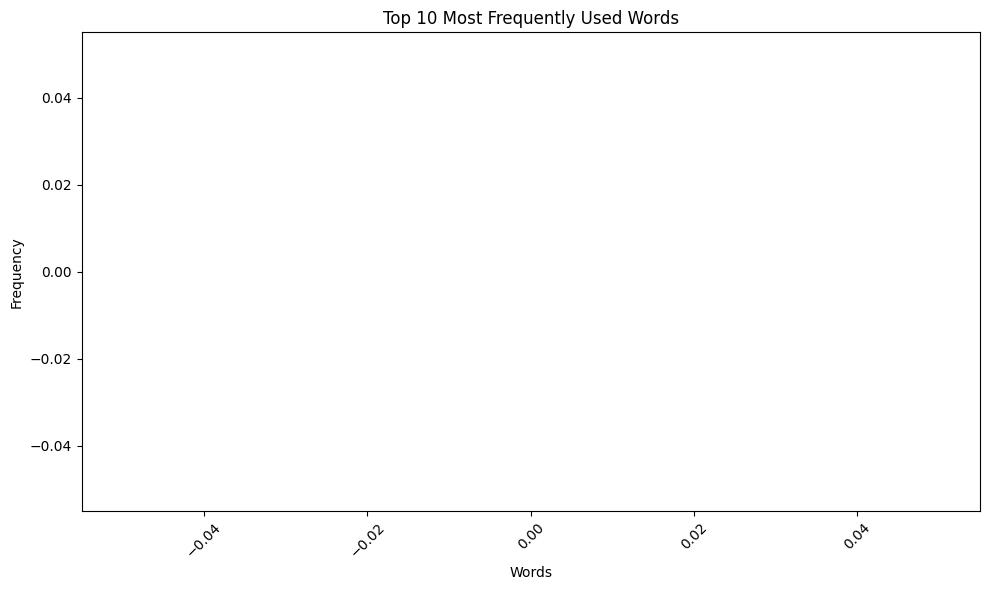

In [15]:
# Word Count
def w_counter(words):
    word_freq = Counter(words)
    common_words = word_freq.most_common()
    word_freq_dict = {"Word": [word for word, freq in common_words], "Frequency": [freq for word, freq in common_words]}
    return word_freq_dict

all_words = [word for sublist in filtered_df['Lemmas'] for word in sublist]

word_freq = pd.DataFrame(w_counter(all_words))

# Select the top 10 words by frequency
top_10_words = word_freq.head(10)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(top_10_words['Word'], top_10_words['Frequency'], color='skyblue')
plt.title("Top 10 Most Frequently Used Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(word_freq)

Empty DataFrame
Columns: [Word, Frequency]
Index: []
